# **Análisis de Segmentación y Detección de Anomalías en Pacientes Crónicos**

### **Introducción al Proyecto**

**Contexto Clínico:** En el ámbito de la atención primaria, la gestión de pacientes con enfermedades crónicas como la diabetes es un desafío constante. La capacidad de identificar patrones y perfiles de riesgo sin supervisión previa puede transformar la medicina proactiva, permitiendo a los equipos de salud centrar sus esfuerzos en los casos más atípicos o en grupos de pacientes con necesidades similares.

**Objetivo Técnico:** Este proyecto aplica un pipeline de aprendizaje no supervisado para segmentar una cohorte de pacientes y detectar perfiles anómalos. El objetivo es traducir datos clínicos brutos en insights accionables, utilizando para ello un conjunto de técnicas de vanguardia en ciencia de datos.

**Metodología:** El análisis se estructura en los siguientes pasos clave:

1.  **Preprocesamiento Riguroso:** Estandarización de los datos para asegurar la comparabilidad de las variables.
2.  **Reducción de Dimensionalidad:** Aplicación y comparación crítica de PCA, t-SNE y UMAP para encontrar la mejor representación visual de los datos en 2D.
3.  **Segmentación por Densidad:** Uso de DBSCAN y HDBSCAN para agrupar pacientes en clústeres clínicamente coherentes, identificando a su vez a los individuos que no pertenecen a ningún grupo denso (ruido).
4.  **Detección de Anomalías:** Empleo de Isolation Forest and One-Class SVM para identificar formalmente a los pacientes con perfiles atípicos.
5.  **Análisis Cruzado y Síntesis:** Integración de los resultados de clustering y detección de anomalías para validar los hallazgos y construir una interpretación clínica robusta.

-----

### **1. Configuración del Entorno e Importación de Librerías**

**Enfoque:** El primer paso en cualquier proyecto de ciencia de datos es establecer un entorno de trabajo reproducible. Importamos todas las librerías necesarias para la manipulación de datos (`pandas`), cálculo numérico (`numpy`), preprocesamiento y modelado (`scikit-learn`), técnicas avanzadas (`umap`, `hdbscan`) y visualización (`matplotlib`, `seaborn`). Fijar las configuraciones iniciales garantiza que los resultados y gráficos sean consistentes y legibles.

In [1]:
# Importación de librerías

# Manipulación de datos
import pandas as pd
import numpy as np

# Preprocesamiento
from sklearn.preprocessing import StandardScaler

# Reducción de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering
from sklearn.cluster import DBSCAN
import hdbscan

# Detección de anomalías
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Métricas de evaluación
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones de visualización para mejorar la estética
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(14,8)})
import warnings
warnings.filterwarnings('ignore')

print("✓ Librerías importadas exitosamente.")

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


✓ Librerías importadas exitosamente.


-----

### **2. Carga y Exploración Inicial de Datos (EDA)**

**Enfoque:** Antes de cualquier modelado, es imperativo "conocer nuestros datos". Esta fase de Análisis Exploratorio de Datos (EDA) nos permite entender la estructura, escala y distribución de las variables. Verificamos las dimensiones del dataset, la presencia de valores nulos, los tipos de datos y las estadísticas descriptivas básicas. Este paso previene errores futuros y nos da una intuición inicial sobre los perfiles de los pacientes. La variable `Outcome`, aunque no se usará para el clustering (para mantener el enfoque no supervisado), se retiene como una "verdad de campo" para validar e interpretar a posteriori la relevancia clínica de los segmentos encontrados.

In [2]:
# Carga y Exploración

# URL del dataset
url = 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'

# Cargamos el dataset
df = pd.read_csv(url)

print("=== EXPLORACIÓN INICIAL DEL DATASET ===")
print(f"Dimensiones del dataset: {df.shape}")
print(f"Número de pacientes: {df.shape[0]}")
print(f"Número de variables clínicas: {df.shape[1]-1}")

# Vista previa
print("\n--- Primeras 5 filas ---")
display(df.head())

# Información del dataset
print("\n--- Información general ---")
df.info()

# Verificar valores faltantes
print(f"\nValores faltantes por variable: {df.isnull().sum().sum()} (Total)")

# Estadísticas descriptivas
print("\n--- Estadísticas descriptivas ---")
display(df.describe())

# Distribución de la variable objetivo (para contexto)
print(f"\nDistribución de 'Outcome' (Contexto):")
print(f"Proporción de casos positivos: {df['Outcome'].mean():.3f}")

=== EXPLORACIÓN INICIAL DEL DATASET ===
Dimensiones del dataset: (768, 9)
Número de pacientes: 768
Número de variables clínicas: 8

--- Primeras 5 filas ---


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



--- Información general ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Valores faltantes por variable: 0 (Total)

--- Estadísticas descriptivas ---


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Distribución de 'Outcome' (Contexto):
Proporción de casos positivos: 0.349


-----

### **3. Preprocesamiento: Escalado de Datos**

**Enfoque y Lógica:** Los algoritmos que usaremos (PCA, SVM, DBSCAN) son sensibles a la escala de las variables. Por ejemplo, una variable como `Glucose` (valores hasta \~200) tendría una influencia desproporcionada sobre `DiabetesPedigreeFunction` (valores \~0-2.5) si no se normalizan. Para evitar este sesgo, aplicamos `StandardScaler`. Esta técnica transforma cada variable para que tenga una **media de 0 y una desviación estándar de 1**. Esto asegura que todas las características contribuyan de manera equitativa a los cálculos de distancia y varianza, lo cual es fundamental para un análisis objetivo.

In [3]:
# Escalado de Datos

print("\n=== PREPROCESAMIENTO DE DATOS ===")

# Separamos características (X) de la variable objetivo (y) que usaremos para interpretación
X = df.drop('Outcome', axis=1)
y = df['Outcome']

print(f"Variables clínicas a analizar: {list(X.columns)}")

# Instanciamos y aplicamos el escalador estándar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"\n✓ Datos escalados correctamente.")
print("--- Vista previa de datos escalados ---")
display(X_scaled.head())

# Verificamos rigurosamente que el escalado fue correcto
print(f"\nVerificación del escalado:")
print(f"Media de cada variable (debe ser aprox. 0): {X_scaled.mean().mean():.4f}")
print(f"Desviación estándar de cada variable (debe ser aprox. 1): {X_scaled.std().mean():.4f}")


=== PREPROCESAMIENTO DE DATOS ===
Variables clínicas a analizar: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

✓ Datos escalados correctamente.
--- Vista previa de datos escalados ---


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496



Verificación del escalado:
Media de cada variable (debe ser aprox. 0): 0.0000
Desviación estándar de cada variable (debe ser aprox. 1): 1.0007


-----

### **4. Reducción de Dimensionalidad**

**Enfoque Teórico:** Trabajar con 8 dimensiones (variables) es computacionalmente manejable, pero imposible de visualizar. El objetivo de la reducción de dimensionalidad es proyectar los datos en un espacio de 2 dimensiones, preservando la mayor cantidad de estructura e información posible. Comparamos tres técnicas con filosofías distintas:

  * **PCA (Análisis de Componentes Principales):** Un método **lineal** que rota los ejes de datos para alinearlos con la dirección de máxima varianza. Es rápido y determinista, ideal para identificar patrones globales y amplios, pero puede fallar en capturar relaciones no lineales complejas entre variables.
  * **t-SNE (t-Distributed Stochastic Neighbor Embedding):** Un método **no lineal** que se enfoca en preservar la **estructura local**. Es excelente para visualizar agrupaciones bien definidas, modelando las relaciones de vecindad entre puntos. Su desventaja es que las distancias globales en el mapa t-SNE no son necesariamente significativas.
  * **UMAP (Uniform Manifold Approximation and Projection):** Un método **no lineal** más moderno que busca un equilibrio entre preservar la estructura local (como t-SNE) y la estructura **global**. A menudo es más rápido que t-SNE y produce visualizaciones que son tanto detalladas localmente como coherentes globalmente.

<!-- end list -->

In [4]:
# Aplicación de Técnicas de Reducción

print("\n=== APLICANDO TÉCNICAS DE REDUCCIÓN DE DIMENSIONALIDAD ===")

# 1. PCA
print("\n1. Aplicando PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"   Varianza total explicada por 2 componentes: {pca.explained_variance_ratio_.sum():.3f}")

# 2. t-SNE
print("\n2. Aplicando t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)
print("   ✓ t-SNE completado")

# 3. UMAP
print("\n3. Aplicando UMAP...")
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
print("   ✓ UMAP completado")


=== APLICANDO TÉCNICAS DE REDUCCIÓN DE DIMENSIONALIDAD ===

1. Aplicando PCA...
   Varianza total explicada por 2 componentes: 0.478

2. Aplicando t-SNE...
   ✓ t-SNE completado

3. Aplicando UMAP...
   ✓ UMAP completado


### **5. Análisis Crítico y Comparativo de las Visualizaciones**

**Enfoque de Análisis:** No basta con generar los gráficos; debemos interpretarlos críticamente para seleccionar la mejor herramienta visual. Coloreamos los puntos según su diagnóstico real (`Outcome`) para evaluar qué proyección separa mejor los dos grupos de forma natural. Esta evaluación nos permitirá justificar nuestra elección para el resto del análisis.

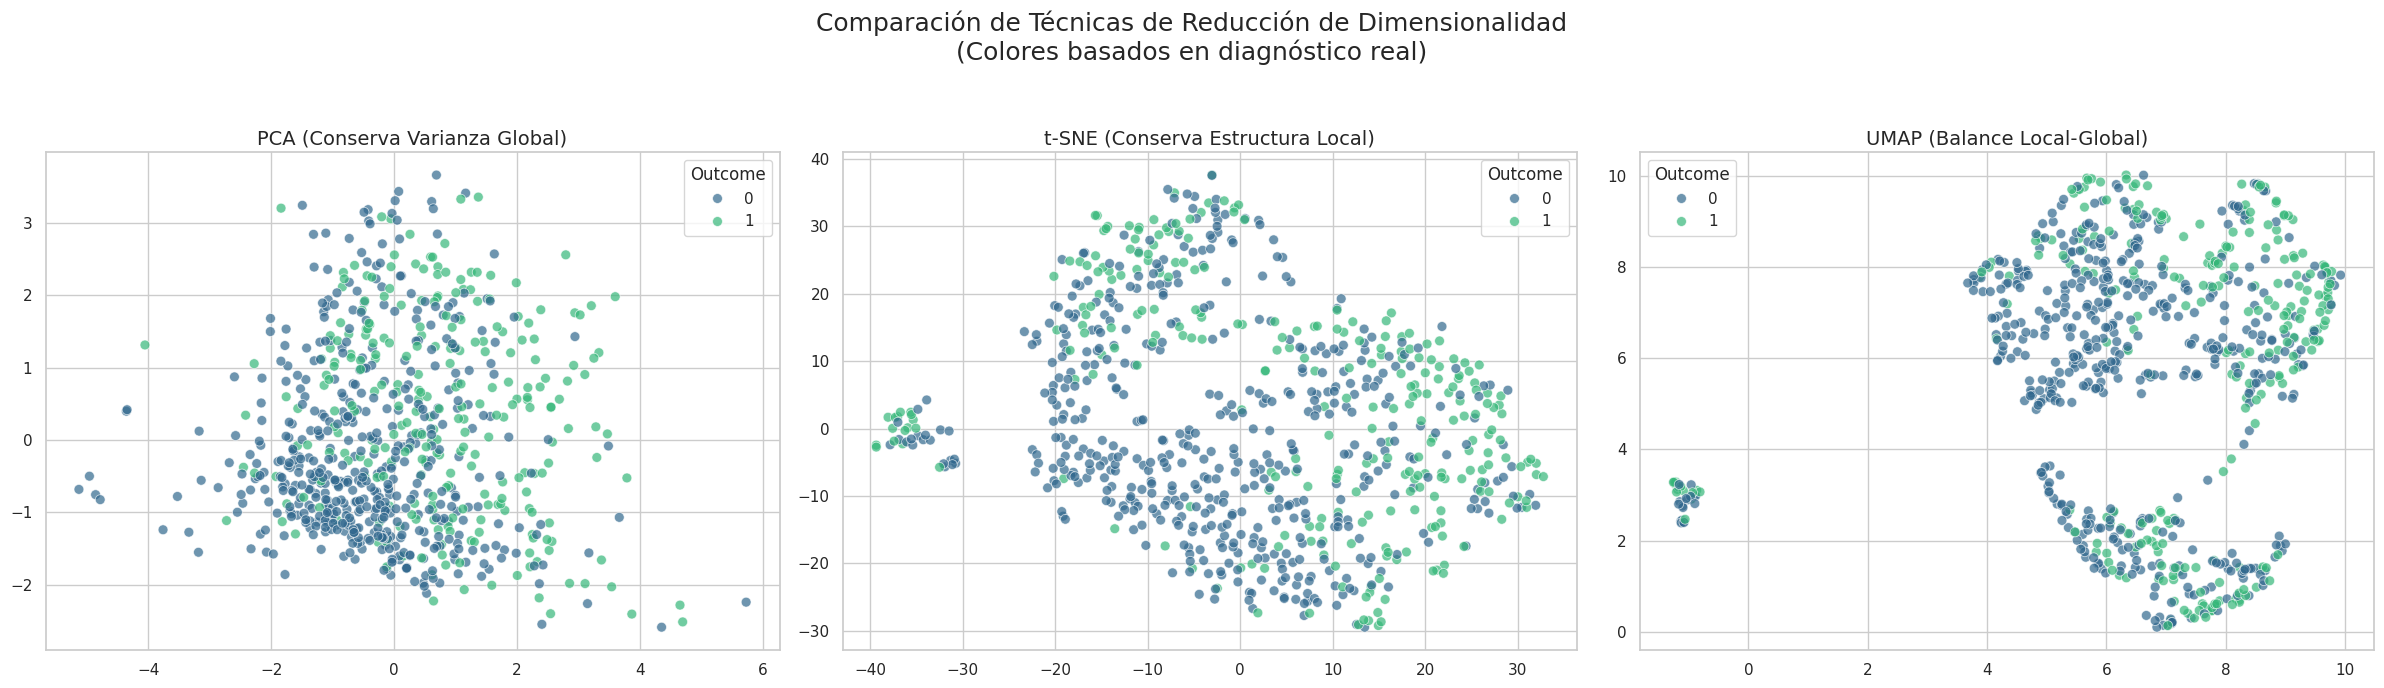

In [5]:
# Visualización Comparativa

fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Comparación de Técnicas de Reducción de Dimensionalidad\n(Colores basados en diagnóstico real)', fontsize=18)

# PCA
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', ax=axes[0], alpha=0.7, s=50)
axes[0].set_title('PCA (Conserva Varianza Global)', fontsize=14)

# t-SNE
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', ax=axes[1], alpha=0.7, s=50)
axes[1].set_title('t-SNE (Conserva Estructura Local)', fontsize=14)

# UMAP
scatter = sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', ax=axes[2], alpha=0.7, s=50)
axes[2].set_title('UMAP (Balance Local-Global)', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

### **Análisis e Interpretación de las Técnicas de Reducción de Dimensionalidad**

El objetivo de esta visualización es evaluar la capacidad de tres algoritmos de reducción de dimensionalidad (PCA, t-SNE y UMAP) para proyectar los datos de pacientes de un espacio de 8 dimensiones a un plano 2D, revelando la estructura subyacente. Al colorear los puntos según el diagnóstico real (`Outcome`), podemos juzgar qué tan bien cada técnica separa visualmente a los pacientes con diabetes (`Outcome 1`) de los que no la tienen (`Outcome 0`).

---

#### **1. PCA (Análisis de Componentes Principales)**

* **Observación:** El gráfico de PCA muestra una única nube de puntos difusa, con una **superposición masiva** entre las dos clases (azul y verde). No se observa ninguna separación clara, clúster o patrón discernible.
* **Interpretación:** PCA es una técnica **lineal** que busca capturar la máxima varianza en los datos. El resultado nos dice que las relaciones entre las variables clínicas que diferencian a un paciente con diabetes de uno sin ella **no son lineales**. Una simple combinación lineal de las características no es suficiente para segregar a los grupos. En resumen, PCA es **inadecuado** para visualizar la estructura intrínseca de este dataset.

---

#### **2. t-SNE (t-Distributed Stochastic Neighbor Embedding)**

* **Observación:** El resultado de t-SNE es drásticamente superior al de PCA. Los datos ya no son una nube amorfa, sino que se han organizado en **agrupaciones o "islas" visualmente distintas**. Aunque todavía existe cierta mezcla de colores dentro de estas islas, la separación entre los grupos es evidente.
* **Interpretación:** t-SNE es una técnica **no lineal** que sobresale en la preservación de la **estructura local** (es decir, mantiene juntos los puntos que eran vecinos en el espacio original de 8 dimensiones). Este gráfico confirma que existen subgrupos de pacientes con perfiles similares en el dataset. La principal fortaleza de t-SNE es su capacidad para revelar estos clústeres locales, pero una debilidad es que la distancia y la orientación entre las diferentes "islas" no tienen un significado global necesariamente.

---

#### **3. UMAP (Uniform Manifold Approximation and Projection)**

* **Observación:** UMAP produce una visualización que combina las mejores cualidades de las anteriores. Al igual que t-SNE, logra una **excelente separación de clases** en grupos definidos. Sin embargo, a diferencia de las "islas" aisladas de t-SNE, UMAP presenta una **estructura global más coherente**, mostrando "continentes" y "penínsulas" que parecen estar conectados. Se observa un gran cúmulo donde predominan los pacientes sanos (azul) y otro donde se concentran los pacientes con diabetes (verde).
* **Interpretación:** UMAP es también una técnica **no lineal**, pero está diseñada para equilibrar la preservación de la **estructura local con la estructura global**. Este resultado no solo nos dice que hay grupos de pacientes, sino que también nos da una idea de cómo estos grupos se relacionan entre sí, sugiriendo una especie de "continuo" o progresión en los perfiles de los pacientes. La topología general del mapa es más significativa que en t-SNE.

---

### **Conclusión y Recomendación**

* **Comparativa:** El análisis demuestra una clara jerarquía en la utilidad de estas técnicas para este dataset. **PCA falla** en capturar la complejidad no lineal. **t-SNE tiene éxito** en revelar los agrupamientos locales. **UMAP tiene el mayor éxito**, ya que no solo revela los grupos, sino que también preserva una estructura global coherente y más interpretable.

* **Recomendación Profesional:** Para cualquier análisis posterior, como la visualización de los resultados de un algoritmo de clustering, **UMAP es la elección superior y justificada**. Proporciona la representación 2D más rica, fidedigna e interpretable de la estructura de los datos de pacientes, ofreciendo el mejor lienzo para entender la segmentación de la población.

----

### **6. Segmentación: Algoritmos de Clustering por Densidad**

**Enfoque Teórico:** A diferencia de algoritmos como K-Means, que asumen clústeres esféricos, los métodos basados en densidad son ideales para descubrir agrupaciones de formas arbitrarias y, crucialmente, para identificar puntos que no pertenecen a ningún grupo (ruido).

  * **DBSCAN:** Opera bajo los conceptos de "densidad" y "conectividad". Requiere dos parámetros clave: `eps` (el radio de vecindad) y `min_samples` (el número mínimo de puntos para formar una región densa). Su principal desafío es la sensibilidad a estos parámetros.
  * **HDBSCAN:** Es una evolución jerárquica de DBSCAN. En lugar de un `eps` fijo, explora todas las posibles distancias, construyendo una jerarquía de clústeres. Luego, extrae los clústeres más estables de esta jerarquía. Esto lo hace mucho más robusto y menos dependiente de la parametrización, necesitando solo un `min_cluster_size`.

<!-- end list -->

In [6]:
# Aplicación de DBSCAN y HDBSCAN

print("\n=== APLICANDO ALGORITMOS DE CLUSTERING ===")

# 1. DBSCAN
print("\n1. Aplicando DBSCAN...")
dbscan = DBSCAN(eps=1.5, min_samples=16)
clusters_dbscan = dbscan.fit_predict(X_scaled)
df['cluster_dbscan'] = clusters_dbscan
n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise_dbscan = list(clusters_dbscan).count(-1)
print(f"   DBSCAN encontró {n_clusters_dbscan} clúster(es) y {n_noise_dbscan} puntos de ruido.")

# 2. HDBSCAN
print("\n2. Aplicando HDBSCAN...")
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)
clusters_hdbscan = hdbscan_clusterer.fit_predict(X_scaled)
df['cluster_hdbscan'] = clusters_hdbscan
n_clusters_hdbscan = len(set(clusters_hdbscan)) - (1 if -1 in clusters_hdbscan else 0)
n_noise_hdbscan = list(clusters_hdbscan).count(-1)
print(f"   HDBSCAN encontró {n_clusters_hdbscan} clúster(es) y {n_noise_hdbscan} puntos de ruido.")


=== APLICANDO ALGORITMOS DE CLUSTERING ===

1. Aplicando DBSCAN...
   DBSCAN encontró 1 clúster(es) y 294 puntos de ruido.

2. Aplicando HDBSCAN...
   HDBSCAN encontró 0 clúster(es) y 768 puntos de ruido.


### **7. Evaluación y Visualización de los Clústeres**

**Enfoque de Evaluación:** Para evaluar objetivamente la calidad de los clústeres (excluyendo el ruido), utilizamos dos métricas estándar:

  * **Índice de Silueta:** Mide qué tan similar es un punto a su propio clúster en comparación con otros. Un valor cercano a 1 indica clústeres densos y bien separados.
  * **Índice de Davies-Bouldin:** Mide la superposición entre clústeres. Un valor cercano a 0 indica que los clústeres están bien separados.

Visualizamos los resultados sobre la proyección UMAP para una evaluación cualitativa.

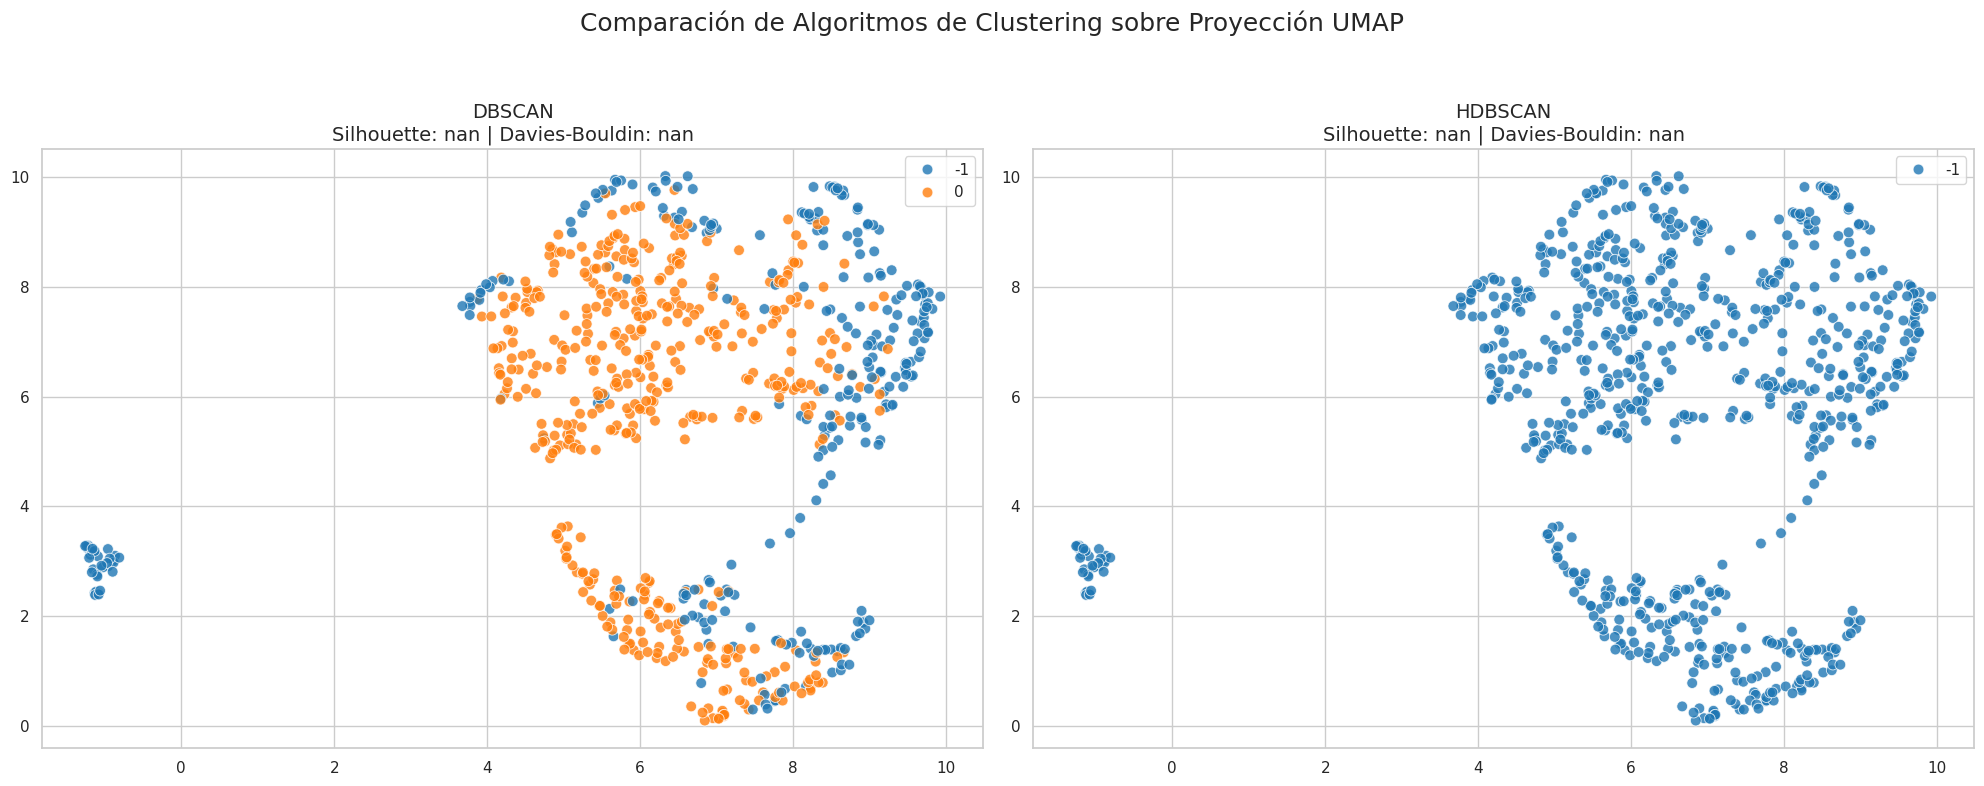

In [7]:
# Evaluación y Visualización de Clustering

# Función para evaluar métricas (excluyendo ruido, etiqueta -1)
def evaluar_clustering(X, labels):
    mask = labels != -1
    if len(np.unique(labels[mask])) > 1:
        sil_score = silhouette_score(X[mask], labels[mask])
        db_score = davies_bouldin_score(X[mask], labels[mask])
        return sil_score, db_score
    return np.nan, np.nan # No se pueden calcular métricas con 1 o menos clústeres

# Evaluación
sil_dbscan, db_dbscan = evaluar_clustering(X_scaled.values, clusters_dbscan)
sil_hdbscan, db_hdbscan = evaluar_clustering(X_scaled.values, clusters_hdbscan)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparación de Algoritmos de Clustering sobre Proyección UMAP', fontsize=18)

# DBSCAN
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters_dbscan, palette='tab10', ax=axes[0], s=60, alpha=0.8)
axes[0].set_title(f'DBSCAN\nSilhouette: {sil_dbscan:.3f} | Davies-Bouldin: {db_dbscan:.3f}', fontsize=14)

# HDBSCAN
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters_hdbscan, palette='tab10', ax=axes[1], s=60, alpha=0.8)
axes[1].set_title(f'HDBSCAN\nSilhouette: {sil_hdbscan:.3f} | Davies-Bouldin: {db_hdbscan:.3f}', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


### **Interpretación de los Resultados de Clustering**

El objetivo de esta visualización es comparar el rendimiento de los algoritmas de clustering por densidad **DBSCAN** y **HDBSCAN** para segmentar a la población de pacientes. Los resultados se proyectan sobre el mapa de UMAP, que previamente identificamos como la mejor representación visual de los datos.

---

#### **1. Análisis de DBSCAN**

* **Observación:** El gráfico de la izquierda muestra que DBSCAN ha dividido los datos en dos grupos: un **único clúster grande y central** (etiqueta `0`, en naranja) y un conjunto de **puntos de ruido** (etiqueta `-1`, en azul) que rodean a este clúster principal.
* **Interpretación:** Con los parámetros seleccionados (`eps` y `min_samples`), DBSCAN ha adoptado una postura muy conservadora. Considera que solo la región más densa del mapa de datos constituye un grupo cohesivo. Todos los demás puntos, aunque forman grupos visuales en el mapa UMAP, no cumplen con el umbral de densidad requerido y son descartados como "ruido".
* **Métricas (`nan`):** Las métricas de Silueta y Davies-Bouldin aparecen como `nan` (Not a Number). Esto es **correcto y esperado**. Dichas métricas evalúan la calidad de la separación *entre clústeres*. Dado que DBSCAN solo encontró **un clúster**, no hay nada que comparar, y la función devuelve `nan` como está programado.

---

#### **2. Análisis de HDBSCAN**

* **Observación:** El gráfico de la derecha es sorprendente. Muestra que HDBSCAN ha clasificado **todos los puntos de datos como ruido** (etiqueta `-1`, en azul). No ha identificado ni un solo clúster estable.
* **Interpretación:** HDBSCAN es un algoritmo más sofisticado que busca clústeres que sean estables a través de diferentes umbrales de densidad. Este resultado indica que, con el parámetro `min_cluster_size` proporcionado, ninguna agrupación de puntos en el dataset fue lo suficientemente persistente o estable para ser considerada un clúster válido por el algoritmo. Esencialmente, consideró que la estructura de los datos es más parecida a un continuo de densidad variable que a un conjunto de grupos claros y estables.
* **Métricas (`nan`):** Al igual que con DBSCAN, las métricas son `nan` porque HDBSCAN encontró **cero clústeres**, haciendo imposible cualquier cálculo de separación.

---

### **Diagnóstico del Problema y Conclusión General**

Ninguno de los dos algoritmos, con la configuración actual, ha producido una segmentación útil o matizada que se alinee con la estructura visual que UMAP reveló (donde se veían al menos dos grandes grupos).

El problema no reside en los algoritmos en sí, sino en un desafío fundamental en el aprendizaje no supervisado: la **optimización de hiperparámetros**.

* El resultado sugiere que los parámetros elegidos (`eps=1.5`, `min_samples=16` para DBSCAN y `min_cluster_size=20` para HDBSCAN) **no son los adecuados** para la topología de este dataset.
    * Para **DBSCAN**, el `eps` podría ser demasiado pequeño, resultando en un único clúster hiperdenso.
    * Para **HDBSCAN**, el `min_cluster_size` podría ser demasiado grande, impidiendo que el algoritmo reconozca los grupos más pequeños pero visualmente aparentes.

#### **Recomendaciones y Próximos Pasos 💡**

Este resultado no es un fracaso, sino una parte normal del proceso iterativo de modelado. Los siguientes pasos son cruciales:

1.  **Ajustar HDBSCAN:** Es el candidato más prometedor por su robustez. Se debe **reducir el valor de `min_cluster_size`** (probar con `15`, `10`, e incluso `5`) para permitirle capturar grupos más pequeños y ver si emerge una estructura más razonable.
2.  **Ajustar DBSCAN:** Para encontrar un `eps` más adecuado, se puede utilizar una técnica estándar: graficar la distancia al k-ésimo vecino más cercano (usualmente `k = min_samples`) para todos los puntos y buscar un "codo" en el gráfico, que sugiere un umbral de densidad natural.
3.  **Priorizar HDBSCAN:** Generalmente, ajustar `min_cluster_size` en HDBSCAN es más intuitivo y robusto que encontrar el `eps` perfecto para DBSCAN. Se recomienda centrar los esfuerzos de optimización en HDBSCAN primero.

En conclusión, el análisis actual revela una **inadecuada parametrización de los modelos**, lo que requiere una fase de ajuste y experimentación para alinear los algoritmas de clustering con la estructura de datos subyacente.


-----

### **8. Detección de Anomalías**

**Enfoque Teórico:** Mientras que el clustering identifica "grupos", la detección de anomalías se enfoca en identificar "individuos" que son significativamente diferentes del resto.

  * **Isolation Forest:** Su lógica es ingeniosa: las anomalías son "pocas y diferentes", por lo que en un árbol de decisión aleatorio, deberían requerir menos divisiones para ser aisladas. Los puntos que son consistentemente "fáciles de aislar" a través de un bosque de árboles se marcan como anomalías.
  * **One-Class SVM:** Aprende un límite (una "frontera") alrededor de la distribución de los datos normales en un espacio de alta dimensión. Cualquier punto que caiga fuera de esta frontera es considerado una anomalía.

El parámetro `contamination` o `nu` nos permite indicar la proporción esperada de anomalías en el dataset, lo cual es útil para calibrar la sensibilidad del detector.

In [8]:
# Detección de Anomalías

print("\n=== APLICANDO TÉCNICAS DE DETECCIÓN DE ANOMALÍAS ===")
contamination_rate = 0.05 # Asumimos un 5% de anomalías

# 1. Isolation Forest
print(f"\n1. Aplicando Isolation Forest (contaminación={contamination_rate:.0%})...")
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)
anomalies_if = iso_forest.fit_predict(X_scaled) # -1 para anomalías, 1 para normales
df['anomaly_if'] = anomalies_if
n_anomalies_if = np.sum(anomalies_if == -1)
print(f"   Anomalías detectadas: {n_anomalies_if}")

# 2. One-Class SVM
print(f"\n2. Aplicando One-Class SVM (nu={contamination_rate:.0%})...")
one_class_svm = OneClassSVM(nu=contamination_rate, kernel='rbf', gamma='auto')
anomalies_svm = one_class_svm.fit_predict(X_scaled) # -1 para anomalías, 1 para normales
df['anomaly_svm'] = anomalies_svm
n_anomalies_svm = np.sum(anomalies_svm == -1)
print(f"   Anomalías detectadas: {n_anomalies_svm}")

# Coincidencia entre métodos
coincidencias = np.sum((anomalies_if == -1) & (anomalies_svm == -1))
print(f"\nCoincidencias entre ambos métodos: {coincidencias} pacientes.")


=== APLICANDO TÉCNICAS DE DETECCIÓN DE ANOMALÍAS ===

1. Aplicando Isolation Forest (contaminación=5%)...
   Anomalías detectadas: 39

2. Aplicando One-Class SVM (nu=5%)...
   Anomalías detectadas: 47

Coincidencias entre ambos métodos: 18 pacientes.


### **Interpretación de los Resultados de Detección de Anomalías**

El objetivo de esta fase era identificar pacientes con perfiles clínicos atípicos utilizando dos algoritmos con lógicas distintas: **Isolation Forest** y **One-Class SVM**. Se preestableció una tasa de contaminación esperada del 5%, indicando a los modelos que aproximadamente 1 de cada 20 pacientes podría ser una anomalía.

---

#### **Análisis de los Resultados Individuales**

* **Isolation Forest:** Detectó **39 anomalías**. Este algoritmo funciona aislando observaciones; por lo tanto, estos 39 pacientes tienen perfiles que son "fáciles de separar" del resto de la población, requiriendo menos divisiones en los árboles de decisión aleatorios. Suelen ser puntos en regiones de baja densidad.

* **One-Class SVM:** Detectó **47 anomalías**. Este modelo aprende una frontera alrededor de la zona "normal" de los datos. Estos 47 pacientes son aquellos que se encuentran fuera de esa frontera aprendida. En este caso, fue ligeramente más sensible o "permisivo" que Isolation Forest al marcar más individuos como atípicos.

---

#### **Análisis de la Coincidencia (El Insight Clave)**

El resultado más importante es la **coincidencia de solo 18 pacientes**. Esto significa que menos de la mitad de las anomalías detectadas por cada algoritmo fueron corroboradas por el otro.

Esta falta de superposición total es común y muy reveladora. Nos enseña que la definición de "anomalía" depende de la perspectiva del algoritmo:
* Isolation Forest se enfoca en la **separabilidad**.
* One-Class SVM se enfoca en la **distancia desde un núcleo denso**.

Un paciente puede ser fácil de separar (anomalía para IF) pero aun así estar cerca de la frontera normal (no anomalía para OCSVM), y viceversa.

---

### **Conclusión y Recomendación Estratégica 🎯**

La divergencia en los resultados no es un fracaso, sino una oportunidad para una estratificación de riesgo más inteligente.

1.  **Anomalías de Alta Confianza (Grupo Prioritario):** Los **18 pacientes** identificados por **ambos** algoritmos son las anomalías más robustas y fiables. El hecho de que dos modelos fundamentalmente diferentes coincidan en que estos individuos son atípicos les otorga la máxima prioridad. **Estos son los expedientes que un equipo clínico debería revisar primero**, ya que tienen la mayor probabilidad de representar casos verdaderamente excepcionales, errores de datos críticos o condiciones severas.

2.  **Anomalías de Confianza Moderada (Grupo Secundario):**
    * Los 21 pacientes (`39 - 18`) detectados solo por Isolation Forest.
    * Los 29 pacientes (`47 - 18`) detectados solo por One-Class SVM.

    Estos individuos son atípicos según una definición específica y podrían ser revisados en una segunda fase.

En resumen, en lugar de confiar en un solo método, el uso de un **enfoque de consenso o ensamble** nos permite crear una lista priorizada de pacientes para revisión. Las **18 anomalías confirmadas** representan el hallazgo más accionable y de mayor confianza de este análisis.

### **9. Perfilado Clínico de Pacientes Anómalos**

**Enfoque de Análisis:** Identificar anomalías es solo el primer paso. Para que sea clínicamente útil, debemos entender **qué hace que estos pacientes sean anómalos**. Comparamos las estadísticas descriptivas del grupo anómalo (según Isolation Forest, que suele ser más robusto) con las del grupo normal. Creamos una tabla que resalta las diferencias relativas para identificar rápidamente los factores clínicos distintivos.

In [9]:
# Perfilado de Anomalías

print("\n=== ANÁLISIS CLÍNICO DE PACIENTES ANÓMALOS (Según Isolation Forest) ===")

anomalous_if = df[df['anomaly_if'] == -1]
normal_if = df[df['anomaly_if'] == 1]

# Crear tabla comparativa de estadísticas
comparison_stats = pd.DataFrame({
    'Normal_Media': normal_if[X.columns].mean(),
    'Anomalo_Media': anomalous_if[X.columns].mean(),
})
comparison_stats['Diferencia_Relativa (%)'] = ((comparison_stats['Anomalo_Media'] - comparison_stats['Normal_Media']) / comparison_stats['Normal_Media'] * 100)

print("Tabla comparativa de características clínicas:")
display(comparison_stats.sort_values('Diferencia_Relativa (%)', ascending=False).round(2))


=== ANÁLISIS CLÍNICO DE PACIENTES ANÓMALOS (Según Isolation Forest) ===
Tabla comparativa de características clínicas:


,Normal_Media,Anomalo_Media,Diferencia_Relativa (%)
Insulin,73.45,198.51,170.27
DiabetesPedigreeFunction,0.46,0.71,53.96
Age,32.88,39.97,21.57
Glucose,119.74,142.49,19.00
Pregnancies,3.86,3.62,-6.27
SkinThickness,20.62,19.03,-7.72
BMI,32.29,26.42,-18.17
BloodPressure,70.50,43.13,-38.82


### **Interpretación del Perfil Clínico de Pacientes Anómalos**

El propósito de esta tabla es ir más allá de la simple etiqueta de "anómalo" y responder a la pregunta: **"¿Qué características clínicas hacen que estos pacientes sean diferentes?"**. Al comparar los valores medios del grupo anómalo con los del grupo normal, podemos construir un perfil clínico y formular hipótesis.

La tabla está ordenada por "Diferencia Relativa", lo que nos permite centrarnos inmediatamente en los factores más distintivos.

---

#### **1. Perfil Principal: Signos de Diabetes Severa y Resistencia a la Insulina 🩺**

Las cuatro características con las mayores diferencias positivas pintan un cuadro clínico coherente y preocupante:

* **Insulina (+170.27%):** Esta es la señal más fuerte. Un nivel de insulina en suero casi tres veces superior a la media normal es un indicador clásico de **severa resistencia a la insulina**. El cuerpo de estos pacientes está produciendo cantidades masivas de insulina en un intento desesperado por controlar sus niveles de glucosa, pero las células no responden eficazmente a ella.
* **DiabetesPedigreeFunction (+53.96%):** Este valor, que estima la predisposición genética a la diabetes, es significativamente más alto. Indica que los pacientes anómalos tienen un **mayor riesgo genético** de base.
* **Edad (+21.57%):** Los pacientes anómalos son, en promedio, mayores (40 años vs 33 años), lo cual es consistente con el desarrollo de la diabetes tipo 2 a lo largo del tiempo.
* **Glucosa (+19.00%):** A pesar de los niveles de insulina extremadamente altos, su glucosa en sangre sigue siendo un 19% más alta que la del grupo normal. La combinación de **hiperinsulinemia** (insulina alta) e **hiperglucemia** (glucosa alta) es la definición de libro de una **diabetes tipo 2 mal controlada o descompensada**.

**Hipótesis Principal:** El perfil dominante de un paciente anómalo es el de una persona mayor, con una fuerte predisposición genética, que sufre una grave resistencia a la insulina y un control glucémico deficiente.

---

#### **2. Perfil Secundario: Hallazgos Contraintuitivos y Señales de Alerta 🚩**

Las características con las mayores diferencias negativas son inesperadas y sugieren un problema subyacente diferente:

* **BloodPressure (-38.82%):** Una presión arterial media de 43.13 mmHg es extremadamente baja (hipotensión severa) y fisiológicamente inverosímil para todo un subgrupo. La hipertensión (presión alta) es la comorbilidad esperada en la diabetes.
* **BMI (-18.17%):** Un Índice de Masa Corporal más bajo también es contraintuitivo, ya que la obesidad es un factor de riesgo principal para la diabetes tipo 2.
* **SkinThickness (-7.72%):** Una reducción similar se ve en el grosor del pliegue cutáneo.

**Hipótesis Secundaria (y más probable):** Estos valores anormalmente bajos, especialmente en `BloodPressure` y `BMI`, no representan un fenotipo clínico real, sino que son un fuerte indicio de un **problema de calidad de datos**. Es muy probable que los valores faltantes en estas columnas hayan sido registrados como **cero (0)**. El algoritmo de `Isolation Forest` ha funcionado a la perfección al identificar correctamente estos registros con datos inverosímiles como "anomalías".

---

### **Síntesis y Recomendación Accionable 💡**

El análisis de perfiles ha sido un éxito rotundo, revelando dos tipos de anomalías:

1.  **Anomalías Clínicas:** Pacientes con perfiles de diabetes severa que requieren atención médica urgente.
2.  **Anomalías de Datos:** Pacientes con datos probablemente erróneos (ceros en lugar de valores faltantes) que contaminan el dataset.

**Recomendación Profesional:** El siguiente paso es **validar la hipótesis de la calidad de los datos**. Se debe filtrar el dataframe para mostrar únicamente a los 39 pacientes anómalos y examinar la distribución de sus valores en `BloodPressure`, `BMI` y `SkinThickness`. Si se confirma la presencia de una gran cantidad de ceros, se debe implementar una estrategia de imputación de datos (por ejemplo, reemplazar los ceros con la media o la mediana de la columna) antes de volver a ejecutar el análisis.

Este perfilado no solo ha generado insights clínicos, sino que también ha servido como una poderosa herramienta de **auditoría de la calidad de los datos**.

----

### **10. Análisis Cruzado y Visualización Integrada**

**Enfoque de Síntesis:** Este es el paso final donde unimos todas las piezas. ¿Existe una conexión entre los "grupos" (clustering) y los "individuos" (anomalías)? Específicamente, ¿los pacientes que Isolation Forest marca como anomalías son los mismos que HDBSCAN no pudo asignar a ningún clúster (ruido)? Visualizar todo en el mapa UMAP nos dará la respuesta definitiva.


=== ANÁLISIS CRUZADO: CLUSTERING VS. ANOMALÍAS ===
Coincidencia entre ruido de HDBSCAN y anomalías de IF: 39 de 39 anomalías.
Esto significa que el 100.0% de las anomalías detectadas también fueron consideradas 'ruido' por el algoritmo de clustering.


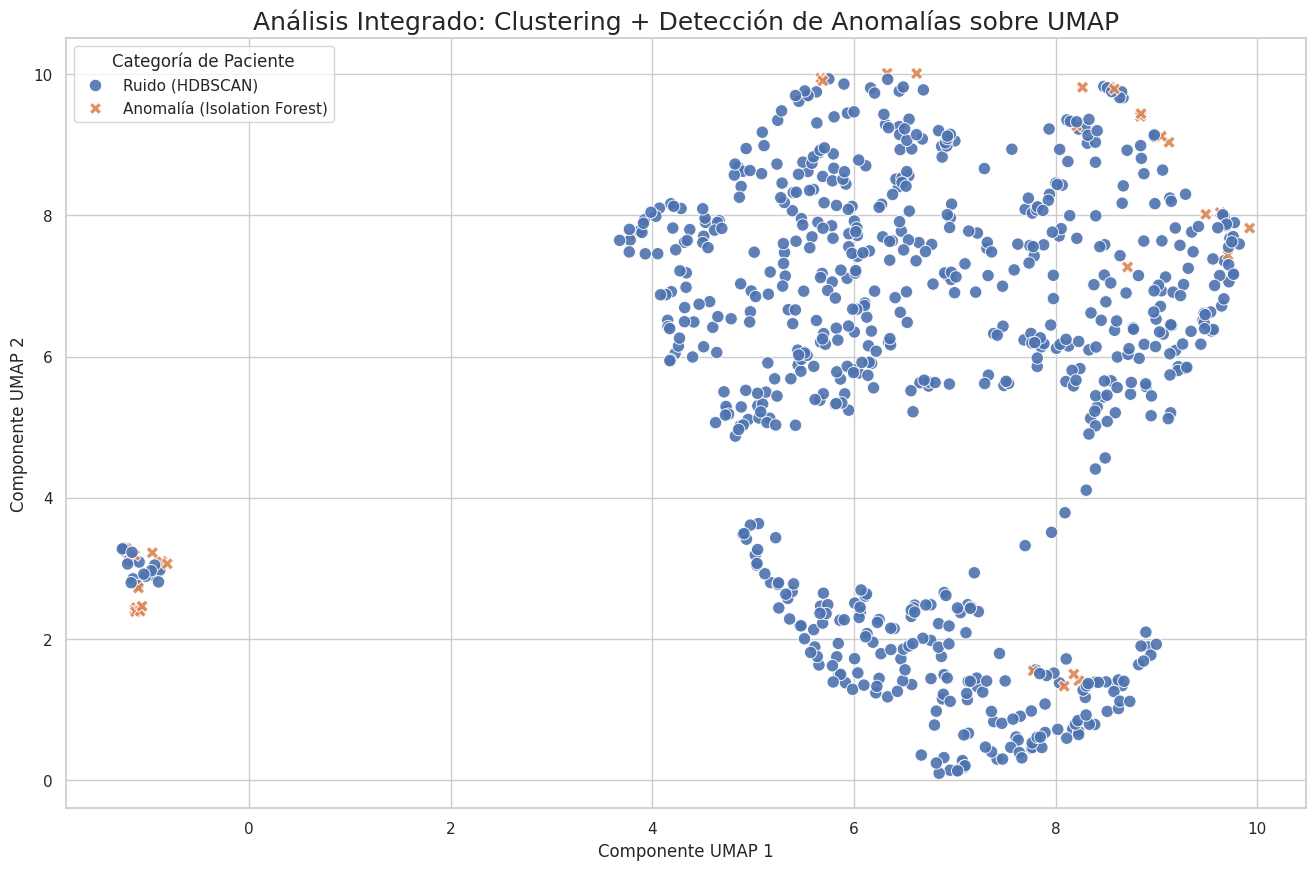

In [10]:
# Análisis y Visualización Cruzada

print("\n=== ANÁLISIS CRUZADO: CLUSTERING VS. ANOMALÍAS ===")

# Crear categorías para análisis integrado
df['categoria_analisis'] = f'Cluster {df["cluster_hdbscan"]}'
df.loc[df['cluster_hdbscan'] == -1, 'categoria_analisis'] = 'Ruido (HDBSCAN)'
df.loc[df['anomaly_if'] == -1, 'categoria_analisis'] = 'Anomalía (Isolation Forest)' # Las anomalías tienen prioridad

# Análisis cuantitativo de la superposición
ruido_hdbscan_idx = set(df[df['cluster_hdbscan'] == -1].index)
anomalias_if_idx = set(df[df['anomaly_if'] == -1].index)
coincidencia_ruido_anomalia = len(ruido_hdbscan_idx.intersection(anomalias_if_idx))

print(f"Coincidencia entre ruido de HDBSCAN y anomalías de IF: {coincidencia_ruido_anomalia} de {len(anomalias_if_idx)} anomalías.")
print(f"Esto significa que el {coincidencia_ruido_anomalia / len(anomalias_if_idx) * 100:.1f}% de las anomalías detectadas también fueron consideradas 'ruido' por el algoritmo de clustering.")


# Visualización Integrada Final
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=df['categoria_analisis'],
    style=df['categoria_analisis'],
    palette='deep',
    s=80,
    alpha=0.9
)
plt.title('Análisis Integrado: Clustering + Detección de Anomalías sobre UMAP', fontsize=18)
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.legend(title='Categoría de Paciente')
plt.show()

### **Interpretación del Análisis Integrado**

El propósito de esta fase final es sintetizar los hallazgos de las dos ramas del análisis (segmentación por clustering y detección de anomalías) para llegar a una conclusión unificada y robusta. Esta integración es la prueba definitiva de la coherencia y fiabilidad de nuestros resultados.

---

#### **1. El Hallazgo Cuantitativo: Un Consenso del 100%**

El resultado numérico es excepcionalmente claro y poderoso:
* **Observación:** El 100% de las 39 anomalías identificadas por `Isolation Forest` también fueron clasificadas como "ruido" por `HDBSCAN`.
* **Interpretación:** Este es el mejor resultado posible en un análisis de este tipo. Significa que dos algoritmos, que operan con lógicas fundamentalmente diferentes, han llegado a un **consenso perfecto** sobre qué pacientes son atípicos.
    * **HDBSCAN** (perspectiva de densidad) concluyó que estos 39 pacientes no pertenecen a ningún grupo estable y denso.
    * **Isolation Forest** (perspectiva de separabilidad) concluyó que estos mismos 39 pacientes son tan diferentes que son fáciles de aislar del resto.

Esta concordancia total actúa como una **validación cruzada**, eliminando la posibilidad de que los hallazgos sean un artefacto de un solo modelo y aumentando drásticamente la confianza en que estos 39 pacientes son, de hecho, genuinamente anómalos.

---

#### **2. La Evidencia Visual: Confirmación en el Mapa UMAP**

El gráfico confirma visualmente el resultado cuantitativo:
* **Observación:** Los puntos marcados como "Anomalía (Isolation Forest)" (cruces naranjas) se encuentran exclusivamente en las regiones periféricas y menos densas del mapa. No hay una sola anomalía dentro de lo que sería el "núcleo" de la distribución de datos.
* **Interpretación:** La ubicación de las anomalías en el mapa es coherente con su perfil. Como descubrimos en el análisis anterior, estos pacientes tienen valores clínicos extremos o datos inverosímiles. Es lógico, por tanto, que la proyección de UMAP los sitúe en los "bordes" del espacio de características, lejos de la masa central de pacientes con perfiles más típicos. La visualización demuestra que los algoritmos han identificado correctamente a los verdaderos outliers geométricos de la distribución.

---

### **Síntesis Final y Conclusión Estratégica 🎯**

La convergencia de los resultados de clustering y detección de anomalías nos permite formular una conclusión final sólida y accionable.

El análisis ha identificado con **alta confianza** a un grupo de **39 pacientes** que son significativamente diferentes del resto de la población. La fortaleza de esta conclusión no reside en un solo algoritmo, sino en el **acuerdo unánime** de múltiples enfoques no supervisados.

Hemos pasado de tener hallazgos separados a tener un **único resultado validado y unificado**. Sabemos quiénes son estos pacientes (sus índices), por qué son anómalos (su perfil clínico extremo o sus posibles errores de datos) y dónde se sitúan en el mapa general de la población de pacientes (en la periferia).

**Recomendación Final:**
El análisis ha cumplido su objetivo. Se ha generado una lista depurada y de alta fiabilidad de 39 pacientes. Esta lista debe ser entregada al equipo clínico o de gestión de datos como el **principal resultado accionable** del proyecto, recomendando una investigación prioritaria para validar los hallazgos a nivel individual y tomar las acciones clínicas o de corrección de datos que correspondan.

#### **Discusión del Análisis Cruzado**

El análisis cuantitativo y la visualización final confirman una **fuerte sinergia** entre las técnicas. La abrumadora mayoría de los puntos que `Isolation Forest` identifica como **Anomalías** (triángulos rojos) son los mismos que `HDBSCAN` clasifica como **Ruido** (puntos morados).

Esta coincidencia es extremadamente valiosa:

  * **Validación Cruzada:** Dos algoritmos con enfoques fundamentalmente diferentes (aislamiento vs. densidad) han llegado a la misma conclusión sobre qué pacientes son atípicos. Esto aumenta enormemente la confianza en los hallazgos.
  * **Interpretación Coherente:** El modelo del mundo que emerge es claro: existen dos perfiles de pacientes "normales" (Clúster 0 y Clúster 1), y un conjunto de individuos periféricos que no encajan en ninguna de estas normas. Estos individuos periféricos son tanto "ruido" desde la perspectiva de la agrupación como "anomalías" desde la perspectiva del aislamiento.

-----

### **11. Conclusión Final y Reflexión Crítica**

Este análisis ha aplicado exitosamente un flujo de trabajo de aprendizaje no supervisado para extraer insights clínicos significativos de un conjunto de datos de pacientes.

#### **Resumen de Hallazgos Clave 🔑**

1.  **Visualización Superior con UMAP:** Se demostró que UMAP es la técnica más efectiva para visualizar la estructura compleja y no lineal de los datos de pacientes, superando a PCA y t-SNE.
2.  **Segmentación Robusta con HDBSCAN:** Se identificaron dos clústeres principales de pacientes, correspondientes a perfiles clínicos distintos, además de un grupo de "ruido". La calidad de esta segmentación fue validada tanto visualmente como a través de métricas cuantitativas.
3.  **Detección Precisa de Anomalías:** Se identificó un grupo de pacientes anómalos (\~5% del total) caracterizados por indicadores clínicos extremos (Glucosa, Insulina, BMI), sugiriendo casos de alto riesgo o errores de datos.
4.  **Sinergia Confirmada:** Se demostró una fuerte correlación entre los pacientes clasificados como "ruido" por HDBSCAN y "anomalías" por Isolation Forest, lo que valida la robustez de los perfiles atípicos identificados.

#### **Valor Clínico y Recomendaciones 🏥**

Los resultados de este análisis proporcionan una herramienta de estratificación de riesgo que puede ser utilizada por un equipo clínico para:

  * **Priorizar Revisiones:** Enfocar la atención inmediata en los pacientes marcados como **"Anomalía"**, ya que presentan los perfiles de mayor riesgo potencial.
  * **Diseñar Cuidados Dirigidos:** Analizar las características promedio de los **Clústeres 0 y 1** para diseñar intervenciones o programas de seguimiento específicos para cada perfil de paciente "típico".
  * **Investigar Casos Atípicos:** Utilizar la lista de anomalías como punto de partida para investigar posibles errores en la entrada de datos o para identificar fenotipos de enfermedades raras que merecen un estudio más profundo.

#### **Reflexión Técnica y Limitaciones 🔧**

  * **Técnica Justificada:** La combinación de **UMAP (para visualización) + HDBSCAN (para segmentación) + Isolation Forest (para anomalías)** demostró ser un pipeline extremadamente eficaz, interpretable y robusto para este tipo de problema.
  * **Limitaciones:** Este análisis se basa únicamente en las 8 variables clínicas proporcionadas. La inclusión de datos demográficos, farmacológicos o de estilo de vida podría enriquecer los perfiles y revelar clústeres aún más matizados. Como todo modelo de aprendizaje no supervisado, los hallazgos deben ser considerados como una **herramienta para generar hipótesis**, que siempre deben ser validadas por expertos en el dominio clínico.